In [103]:
from os.path import join
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.colors import LogNorm
from tqdm import tqdm

In [210]:
with open('/Users/zachkeskinen/Documents/temp/modeling/output/v20220210-aspectright_forcedepthmatch/ID1.pro') as f:
    lines = f.readlines()
i = j = k = m = 0
res = pd.DataFrame()
for l in lines:
    if '0500,' in l:
        if i != 0:
            # res = res.append(d, ignore_index= True)
            res = pd.concat([res, pd.DataFrame.from_dict([d])])
        i += 1
        d = {'date':l.replace('0500,','').replace('\n','')}
    if '0501,' in l:
        j += 1
        assert j == i
        d['heights'] = l.replace('0501,','').replace('\n','')
    if '0502,' in l:
        k += 1
        d['densities'] = l.replace('0502,','').replace('\n','')
    if '0521,' in l:
        m += 1
        assert m == k
        d['conductivities'] = l.replace('0521,','').replace('\n','')
res = res[1:]
res = res.set_index('date')

heights = np.linspace(0,140,29)
extracted_temps = pd.DataFrame(columns = heights, index = res.index)
for dt in tqdm(res.index):
    if not pd.isnull(res.loc[dt, 'conductivities']):
        model_heights = np.array([float(x) for x in res.loc[dt, 'heights'].split(',')[1:]])
        conductivities = np.array([float(x) for x in res.loc[dt, 'conductivities'].split(',')[1:]])
        for h in extracted_temps.columns:
            if h < model_heights[-1]+5:
                hdiff = float(h) - model_heights
                idx = (np.abs(hdiff - 0)).argmin()
                extracted_temps.loc[dt, h] = conductivities[idx]
extracted_temps.index = pd.to_datetime(extracted_temps.index, dayfirst=True)

100%|██████████| 4296/4296 [00:06<00:00, 677.02it/s] 


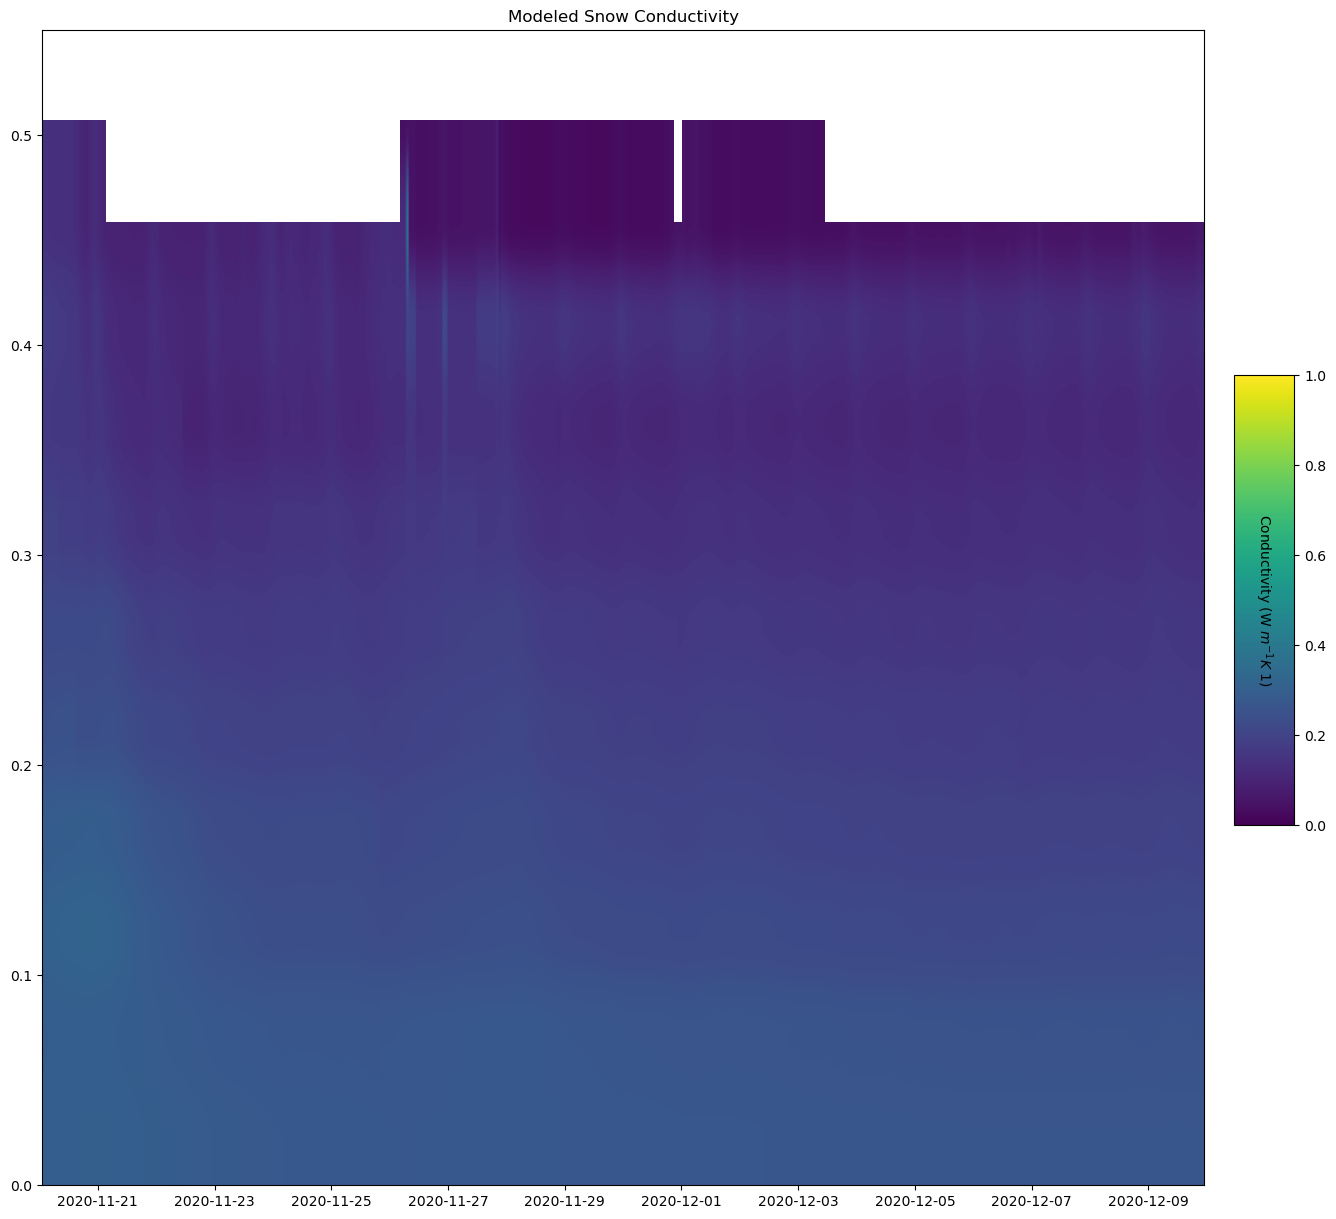

In [224]:
temp_clear = extracted_temps.loc[(extracted_temps.index > df.index[0]) & (extracted_temps.index < df.index[-1])]
arr = temp_clear.to_numpy(dtype = float)
arr = np.rot90(arr)
# Create your x-limits. Using two of your unix timestamps you first
# create a list of datetime.datetime objects using map.
x_lims = pd.to_datetime([temp_clear.index[0],temp_clear.index[-1]])

# You can then convert these datetime.datetime objects to the correct
# format for matplotlib to work with.
x_lims = mdates.date2num(x_lims)

f,ax = plt.subplots(1,1, figsize=(15,15))
sp = plt.imshow(arr, aspect = 'auto', extent = (x_lims[0], x_lims[1],0,1.4), vmin = 0, vmax = 1)
plt.title('Modeled Snow Conductivity')
plt.ylim(0, .55)
ax.xaxis_date()

# f.subplots_adjust(right=0.9)
cbar_ax = f.add_axes([0.92, 0.35, 0.04, 0.3])
cbar = f.colorbar(sp, cax=cbar_ax)
cbar.set_label('Conductivity (W $m^{-1} K ^ {1}$)', rotation=270, labelpad=-37)
#plt.savefig(os.path.join(fig_dir, 'meas_model_temp.png'), dpi = 300)

In [165]:
fp = '/Users/zachkeskinen/Documents/temp/data/snowschool/iFlow/zach_ke_clear_sub.csv'
df = pd.read_csv(fp, index_col = 'Time', parse_dates = True)
for col in df.columns:
    j = False
    prev = 0
    for i, row in df.iterrows():
        v = df.loc[i, col]
        if v < 0 and not j:
            j = prev
            v = abs(v) + prev
        elif v < 0 and j:
            v = abs(v) + j
        else:
            prev = v
            j = False
        if v != df.loc[i, col]:
            df.loc[i, col] = v

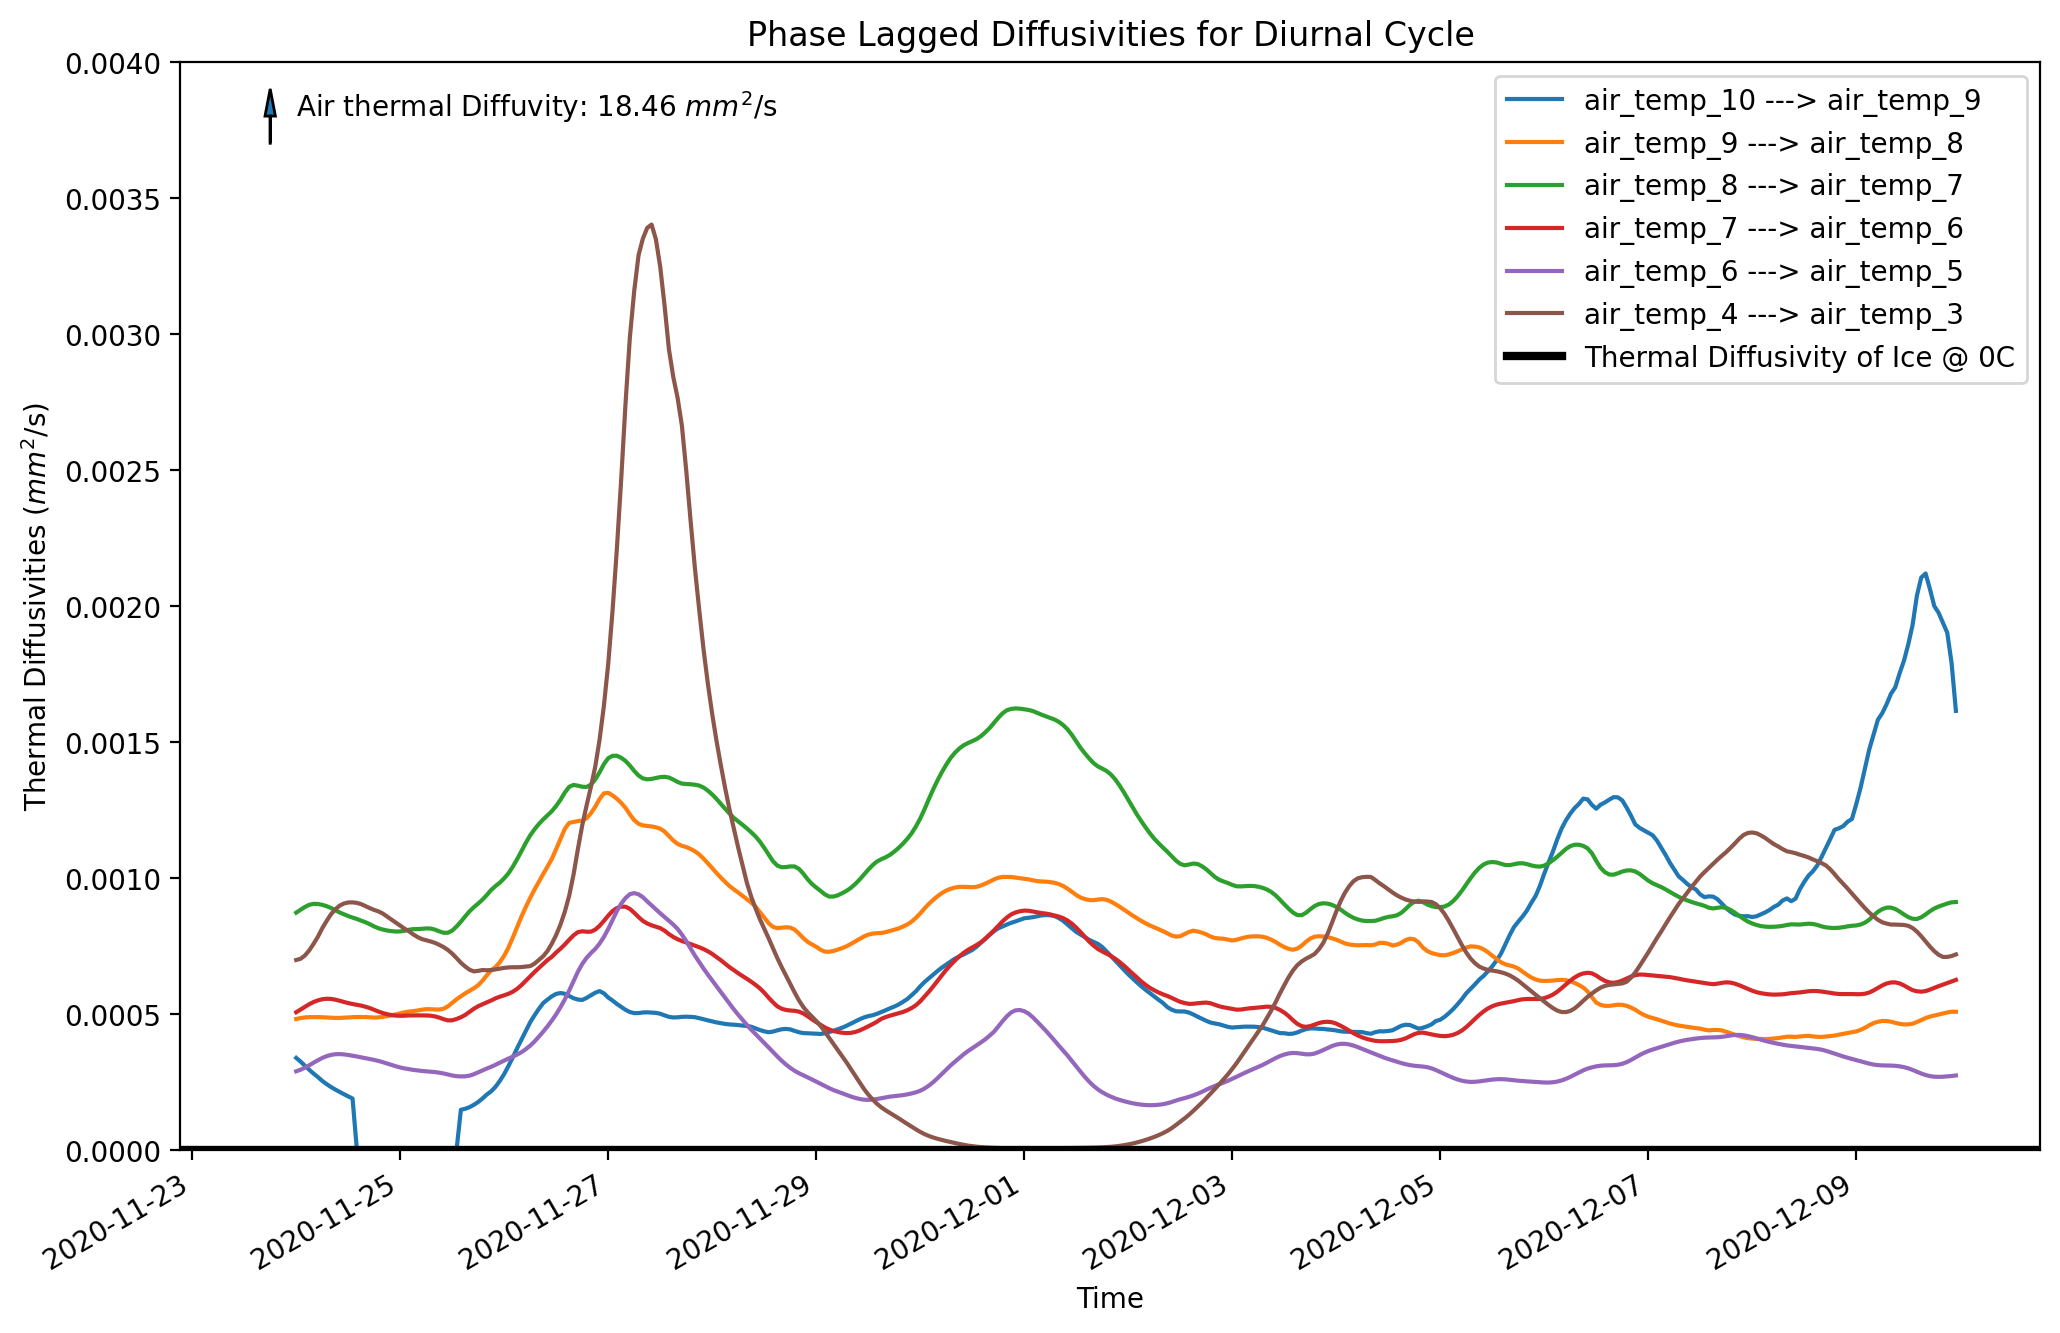

In [18]:
plt.rcParams['text.usetex'] = False
fig, ax = plt.subplots(figsize = (12,8), dpi = 200)
cols = [c for c in df.columns if c !='air_temp_3 ---> air_temp_2']
cols = [c for c in cols if c !='air_temp_5 ---> air_temp_4']
(df*1e3)[cols][df.index > pd.to_datetime('2020-11-24')].plot(ax = ax)
ax.set_ylim(0, 4e-3)
ax.text(pd.to_datetime('2020-11-24'), 0.0038, 'Air thermal Diffuvity: 18.46 $mm^{2}$/s')
ax.arrow(pd.to_datetime('2020-11-23 18:00'), 0.0037, 0, 0.0002, length_includes_head = True, head_length = 0.0001, head_width = 0.1)
ax.axhline(1e-7, color = 'black', linewidth = 3, label = 'Thermal Diffusivity of Ice @ 0C')
plt.legend()
plt.title('Phase Lagged Diffusivities for Diurnal Cycle')
plt.ylabel('Thermal Diffusivities ($mm^{2}$/s)')
phase_fig_dir = '/Users/zachkeskinen/Documents/temp/figures/phase_diffusivities'
plt.savefig(join(phase_fig_dir, 'clear_sub_test.png'))


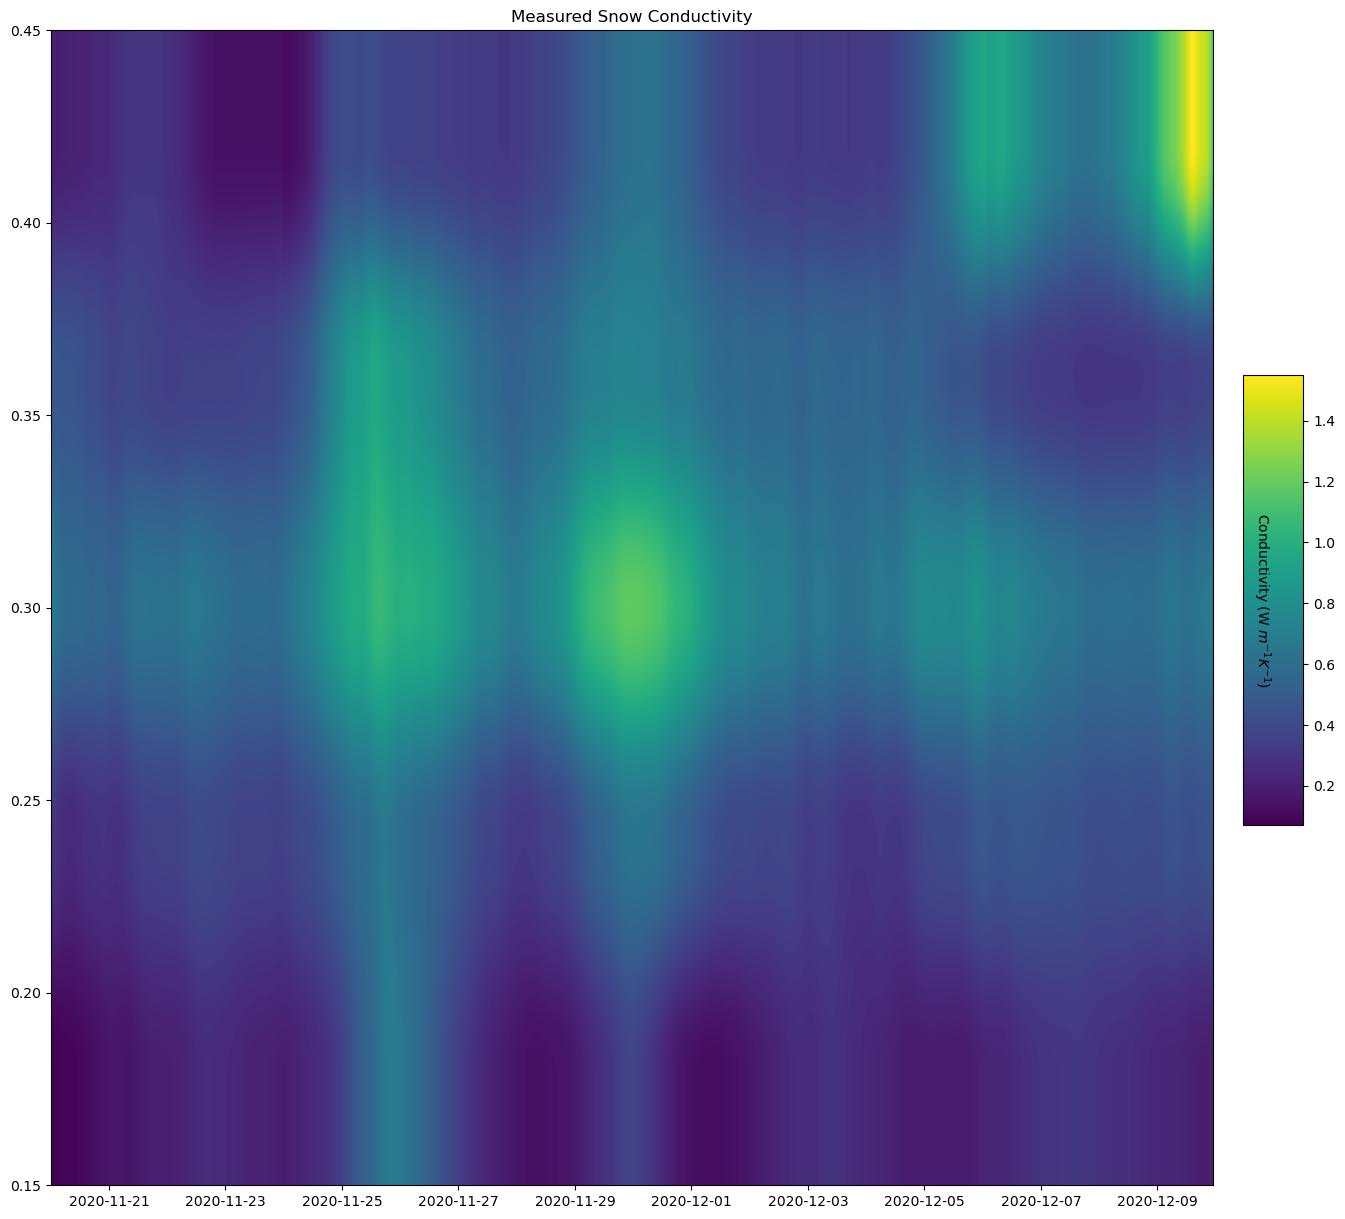

In [162]:
cor = df.copy()
cor = cor.drop(['air_temp_5 ---> air_temp_4','air_temp_4 ---> air_temp_3','air_temp_3 ---> air_temp_2'], axis = 1)
cor = cor.loc[cor.index > '2020-11-22']
# cor.loc[cor['air_temp_5 ---> air_temp_4']>0.0005,'air_temp_5 ---> air_temp_4'] = np.nan
arr = cor.to_numpy(dtype = float)
arr = np.flipud(np.rot90(arr))
arr = arr
# convert to thermal conductivity:
p = 350 #kg/m3
Cp = 2090 #J/kg°C
arr = arr*p*Cp
# Create your x-limits. Using two of your unix timestamps you first
# create a list of datetime.datetime objects using map.
x_lims = pd.to_datetime([df.index[0],df.index[-1]])

# You can then convert these datetime.datetime objects to the correct
# format for matplotlib to work with.
x_lims = mdates.date2num(x_lims)

f,ax = plt.subplots(1,1, figsize=(15,15))
sp = plt.imshow(arr, aspect = 'auto', extent = (x_lims[0], x_lims[1],.15,.45), interpolation=None) #, norm=LogNorm(vmin=0.1, vmax=10)
plt.title('Measured Snow Conductivity')
# plt.ylim(0, .45)
ax.xaxis_date()

# f.subplots_adjust(right=0.9)
cbar_ax = f.add_axes([0.92, 0.35, 0.04, 0.3])
cbar = f.colorbar(sp, cax=cbar_ax)
cbar.set_label('Conductivity (W $m^{-1} K^{-1}$)', rotation=270, labelpad= -45)
#plt.savefig(os.path.join(fig_dir, 'meas_model_temp.png'), dpi = 300)

In [244]:
v = df.iloc[30,4]
p = 350 #kg/m3
Cp = 2090 #J/kg°C
v *p*Cp

0.027325456720530827

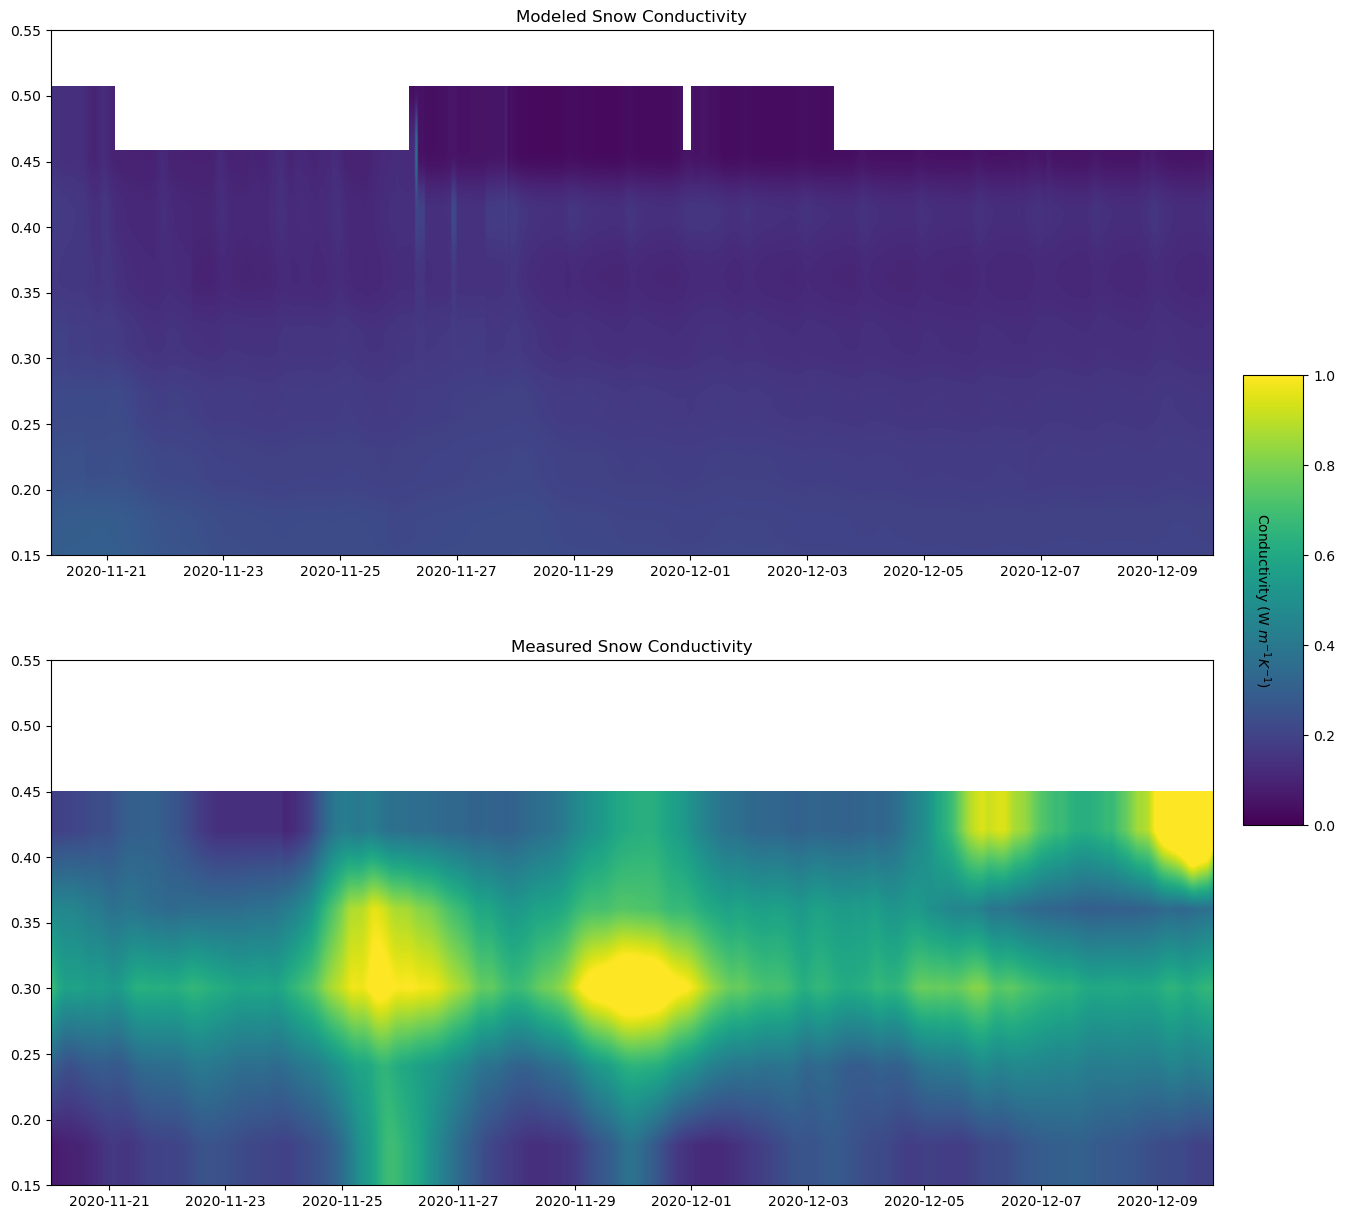

In [246]:
f,axes = plt.subplots(2,1, figsize=(15,15))


temp_clear = extracted_temps.loc[(extracted_temps.index > df.index[0]) & (extracted_temps.index < df.index[-1])]
arr = temp_clear.to_numpy(dtype = float)
arr = np.rot90(arr)
# Create your x-limits. Using two of your unix timestamps you first
# create a list of datetime.datetime objects using map.
x_lims = pd.to_datetime([temp_clear.index[0],temp_clear.index[-1]])

# You can then convert these datetime.datetime objects to the correct
# format for matplotlib to work with.
x_lims = mdates.date2num(x_lims)

sp = axes[0].imshow(arr, aspect = 'auto', extent = (x_lims[0], x_lims[1],0,1.4), vmin = 0, vmax = 1)
axes[0].set_title('Modeled Snow Conductivity')
axes[0].set_ylim(.15, .55)


# # f.subplots_adjust(right=0.9)
# cbar_ax = f.add_axes([0.92, 0.35, 0.04, 0.3])
# cbar = f.colorbar(sp, cax=cbar_ax)
# cbar.set_label('Conductivity (W $m^{-1} K ^ {1}$)', rotation=270, labelpad=-37)
# #plt.savefig(os.path.join(fig_dir, 'meas_model_temp.png'), dpi = 300)

cor = df.copy()
cor = cor.drop(['air_temp_5 ---> air_temp_4','air_temp_4 ---> air_temp_3','air_temp_3 ---> air_temp_2'], axis = 1)
cor = cor.loc[cor.index > '2020-11-22']
# cor.loc[cor['air_temp_5 ---> air_temp_4']>0.0005,'air_temp_5 ---> air_temp_4'] = np.nan
arr = cor.to_numpy(dtype = float)
arr = np.flipud(np.rot90(arr))
arr = arr
# convert to thermal conductivity:
p = 350 #kg/m3
Cp = 2090 #J/kg°C
arr = arr*p*Cp
# Create your x-limits. Using two of your unix timestamps you first
# create a list of datetime.datetime objects using map.
x_lims = pd.to_datetime([df.index[0],df.index[-1]])

# You can then convert these datetime.datetime objects to the correct
# format for matplotlib to work with.
x_lims = mdates.date2num(x_lims)

sp = axes[1].imshow(arr, aspect = 'auto', extent = (x_lims[0], x_lims[1],.15,.45), interpolation='bilinear', vmin = 0, vmax = 1) #, norm=LogNorm(vmin=0.1, vmax=10)
axes[1].set_ylim(.15, .55)
plt.title('Measured Snow Conductivity')
# plt.ylim(0, .45)
for ax in axes:
    ax.xaxis_date()

# f.subplots_adjust(right=0.9)
cbar_ax = f.add_axes([0.92, 0.35, 0.04, 0.3])
cbar = f.colorbar(sp, cax=cbar_ax)
cbar.set_label('Conductivity (W $m^{-1} K^{-1}$)', rotation=270, labelpad= -45)
fig_dir = '/Users/zachkeskinen/Documents/temp/figures/measure_model_conductivities'
plt.savefig(join(fig_dir, 'meas_model_condv1.png'), dpi = 300)